In [208]:
import redback
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
import corner
from bilby.core.prior import Constraint, PriorDict, Uniform, Sine
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

In [209]:
bands = ['lsstg', 'lsstr', 'lssti','lsstz','lssty', 'lsstu', 'uvot::uvw1']
frequencies=[5e9, 2e17]
bandfreqs = (redback.utils.bands_to_frequency(bands))
frequencies.extend(bandfreqs)
frequencies.sort()
frequencies

[5000000000.0,
 308738116672272.25,
 344949774531146.6,
 397287890568202.3,
 481730482385753.06,
 621093082892117.8,
 816711949886849.0,
 1146839759677006.2,
 2e+17]

In [213]:
def afterglow_constraints(parameters):
    constrained_params= parameters.copy()
    
    time=np.linspace(0.1,100,100) #make sure time arrays match
    maxflux=[]
    peaktime=[]
    for i in range(len(parameters['thv'])):
        flux= redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, redshift=0.01, av=0.5,
            base_model='tophat',  thv= parameters['thv'][i], loge0=parameters['loge0'][i] , thc=parameters['thc'][i], logn0=parameters['logn0'][i], 
            p=2.3, logepse=-1.25, logepsb=-2.5, ksin=1.0, g0=1000,
            output_format='flux_density', frequency=frequencies[7])
        maxflux.append(max(flux))
        peaktime.append(time[np.argmax(flux)])
        
    #peak flux must be at times < 200 days
    constrained_params['peak_time']= 200 - np.array(peaktime)
    #peak flux must be greater than 10e-12
    constrained_params['max_flux']= np.array(maxflux) - (10e-12)
    #thv must be greater than thc
    constrained_params['valid_jet']= parameters['thv'] - parameters['thc']
    return constrained_params



In [214]:
priors = PriorDict(conversion_function=afterglow_constraints)
priors['max_flux']= Constraint(minimum=0, maximum=20)
priors['peak_time']= Constraint(minimum=0, maximum=250)
priors.update(redback.priors.get_priors(model='tophat'))
priors['p']=  2.3
priors['loge0']= Uniform(minimum=46, maximum=53, name='loge0', latex_label='$\\log_{10}E_{0}$', unit=None, boundary=None)
priors['redshift']= 0.01
priors['logepse']= -1.25
priors['logepsb']= -2.5
priors['ksin']= 1.0
priors['g0']= 1000

samples=priors.sample(1000)
afterglow_data=pd.DataFrame.from_dict(samples)

In [215]:
time=np.linspace(0.1,100,100)
count=0
for i in range(1000):
    flux= redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, av=0.5,
                base_model='tophat', **afterglow_data.iloc[i], output_format='flux_density', frequency=frequencies[7])
    if np.array(afterglow_data['thv'])[i]>np.array(afterglow_data['thc'])[i] == False:
        print('failed')
    if max(flux)<10e-12:
        print('failed flux')
    if time[np.argmax(flux)] >200:
        print('failed time')
        count+=1
afterglow_data

,redshift,thv,loge0,thc,logn0,p,logepse,logepsb,ksin,g0
0,0.01,0.112468,48.876055,0.047157,-0.378662,2.3,-1.25,-2.5,1.0,1000.0
1,0.01,0.858929,50.386741,0.029535,1.967210,2.3,-1.25,-2.5,1.0,1000.0
2,0.01,0.650527,52.959851,0.014014,-2.121939,2.3,-1.25,-2.5,1.0,1000.0
3,0.01,0.640568,50.630189,0.031764,-4.020972,2.3,-1.25,-2.5,1.0,1000.0
4,0.01,1.375276,48.415181,0.083331,-0.522838,2.3,-1.25,-2.5,1.0,1000.0
...,...,...,...,...,...,...,...,...,...,...
995,0.01,0.524664,52.030479,0.071768,0.532948,2.3,-1.25,-2.5,1.0,1000.0
996,0.01,0.964001,50.256286,0.054313,0.131069,2.3,-1.25,-2.5,1.0,1000.0
997,0.01,1.337499,52.273501,0.029723,-1.464860,2.3,-1.25,-2.5,1.0,1000.0
998,0.01,0.564732,47.985221,0.048013,-2.729750,2.3,-1.25,-2.5,1.0,1000.0


In [192]:
count

0

In [194]:
#priors

that_priorsoff = redback.priors.get_priors(model='tophat')
that_priorsoff['p']=  2.3
that_priorsoff['loge0']= Uniform(minimum=47, maximum=52, name='loge0', latex_label='$\\log_{10}E_{0}$', unit=None, boundary=None)
that_priorsoff['redshift']= 0.01
that_priorsoff['logepse']= -1.25
that_priorsoff['logepsb']= -2.5
that_priorsoff['ksin']= 1.0
that_priorsoff['g0']= 1000
that_priorsoff['logn0']=Uniform(minimum=-2, maximum=1.5, name='logn0', latex_label='$\\log_{10}n_{\\mathrm{ism}}$', unit=None, boundary=None)

that_priorson = redback.priors.get_priors(model='tophat')
that_priorson['p']=  2.3
that_priorson['loge0']= Uniform(minimum=46, maximum=50, name='loge0', latex_label='$\\log_{10}E_{0}$', unit=None, boundary=None)
that_priorson['redshift']= 0.01
that_priorson['logepse']= -1.25
that_priorson['logepsb']= -2.5
that_priorson['ksin']= 1.0
that_priorson['g0']= 1000
that_priorson['logn0']=Uniform(minimum=-2.5, maximum=1.5, name='logn0', latex_label='$\\log_{10}n_{\\mathrm{ism}}$', unit=None, boundary=None)
that_priorson['thv']=Sine(minimum=0, maximum=0.3, name='thv', latex_label='$\\theta_{\\mathrm{observer}}$', unit=None, boundary=None)

kn_priors = redback.priors.get_priors(model='two_layer_stratified_kilonova')
kn_priors['redshift']=0.01
samples=kn_priors.sample(30)
kn_data= pd.DataFrame.from_dict(samples)
kn_priors

{'redshift': DeltaFunction(peak=0.01, name=None, latex_label=None, unit=None),
 'mej': Uniform(minimum=0.01, maximum=0.05, name='mej', latex_label='$M_{\\mathrm{ej}}[M_{\\odot}]$', unit=None, boundary=None),
 'vej_1': Uniform(minimum=0.05, maximum=0.2, name='vej_1', latex_label='$v_{\\mathrm{ej}-1}[c]$', unit=None, boundary=None),
 'vej_2': Uniform(minimum=0.3, maximum=0.5, name='vej_2', latex_label='$v_{\\mathrm{ej}-2}[c]$', unit=None, boundary=None),
 'kappa': Uniform(minimum=1, maximum=30, name='kappa', latex_label='$\\kappa$', unit=None, boundary=None),
 'beta': Uniform(minimum=1.5, maximum=8, name='beta', latex_label='$\\beta$', unit=None, boundary=None)}

In [221]:
def afterglowoff(time, frequency):
    ag_fluxd = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, redshift=0.01, av=0.5,
        base_model='tophat',  thv= 0.84, loge0=49.2 , thc= 0.06, logn0=0.05, p=2.3, logepse=-1.25, logepsb=-2.5, ksin=1, g0=1000, thw=3,
        beta=4, output_format='flux_density', frequency=frequency)
    return ag_fluxd

def afterglowon(time, frequency):
    ag_fluxd = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, redshift=0.01, av=0.5,
        base_model='tophat',  thv= 0.14, loge0=47.7 , thc= 0.06, logn0=0.35, p=2.3, logepse=-1.25, logepsb=-2.5, ksin=1, g0=1000, thw=3,
        beta=4, output_format='flux_density', frequency=frequency)
    return ag_fluxd

def sampleoff(time,frequency):
    sample=that_priorsoff.sample(1)
    ag_fluxd = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, av=0.5,
        base_model='tophat', output_format='flux_density', frequency=frequency, **sample)
    
    while time[np.argmax(ag_fluxd)]<= 0.1 or np.any(ag_fluxd < 10e-25):
        sample=that_priorsoff.sample(1)
        ag_fluxd = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, av=0.5,
            base_model='tophat', **sample, output_format='flux_density', frequency=frequency)
    
    return ag_fluxd

def sampleon(time,frequency):
    sample=that_priorson.sample(1)
    ag_fluxd = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, av=0.5,
        base_model='tophat', output_format='flux_density', frequency=frequency, **sample)
    
    while time[np.argmax(ag_fluxd)]> 0.1 or np.any(ag_fluxd < 10e-25):
        sample=that_priorson.sample(1)
        ag_fluxd = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, av=0.5,
            base_model='tophat', **sample, output_format='flux_density', frequency=frequency)
    
    return ag_fluxd

def agsample(time, frequency):
    sample=priors.sample(1)
    ag_fluxd = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, av=0.5,
        base_model='tophat', output_format='flux_density', frequency=frequency, **sample)
    while np.any(ag_fluxd < 10e-25):
        sample=priors.sample(1)
        ag_fluxd = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, av=0.5,
            base_model='tophat', **sample, output_format='flux_density', frequency=frequency)

def knsample(time, frequency, **sample):
    kn_fluxd =  redback.transient_models.extinction_models.extinction_with_kilonova_base_model(time=time, av=0.5,
        base_model='two_layer_stratified_kilonova', output_format='flux_density', frequency=frequency, **sample)
   
    return kn_fluxd



In [222]:
time= np.linspace(0.1,100,100)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(7,7),sharex=True, sharey=True)

ax[0,0].loglog(time, afterglowoff(time, frequencies[0]), c='k')
ax[0,1].loglog(time, afterglowoff(time, frequencies[1]), c='k')
ax[0,2].loglog(time, afterglowoff(time, frequencies[2]), c='k')
ax[1,0].loglog(time, afterglowoff(time, frequencies[3]), c='k')
ax[1,1].loglog(time, afterglowoff(time, frequencies[4]), c='k')
ax[1,2].loglog(time, afterglowoff(time, frequencies[5]), c='k')
ax[2,0].loglog(time, afterglowoff(time, frequencies[6]), c='k')
ax[2,1].loglog(time, afterglowoff(time, frequencies[7]), c='k')
#ax[2,2].loglog(time, afterglowoff(time, frequencies[8]), c='k')

for i in range(20):
    ax[0,0].loglog(time, sampleoff(time, frequencies[0]), c='magenta', ls='--')
    ax[0,1].loglog(time, sampleoff(time, frequencies[1]), c='r', ls='--')
    ax[0,2].loglog(time, sampleoff(time, frequencies[2]), c='orange', ls='--')
    ax[1,0].loglog(time, sampleoff(time, frequencies[3]), c='y', ls='--')
    ax[1,1].loglog(time, sampleoff(time, frequencies[4]), c='g', ls='--')
    ax[1,2].loglog(time, sampleoff(time, frequencies[5]), c='c', ls='--')
    ax[2,0].loglog(time, sampleoff(time, frequencies[6]), c='b', ls='--')
    ax[2,1].loglog(time, sampleoff(time, frequencies[7]), c='purple', ls='--')    
    #ax[2,2].plot(time, sampled(time, frequencies[8]), c='k', ls='--')


f1 = mpatches.Patch(color='magenta', label='5e9 Hz')
f2 = mpatches.Patch(color='r', label='308738116672272.25 Hz')
f3 = mpatches.Patch(color='orange', label='344949774531146.6 Hz')
f4 = mpatches.Patch(color='y', label='397287890568202.3 Hz')
f5 = mpatches.Patch(color='g', label='481730482385753.06 Hz')
f6 = mpatches.Patch(color='c', label='621093082892117.8 Hz')
f7 = mpatches.Patch(color='b', label='816711949886849.0 Hz')
f8 = mpatches.Patch(color='purple', label='1146839759677006.2 Hz')
#f9 = mpatches.Patch(color='k', label='2e17 Hz')
fix = Line2D([0],[0],color='k', ls='solid', label='fixed params')
samp = Line2D([0],[0],color='grey', ls='dashed',label='sampled')

fig.text(0.5, 0.04, 'time after GRB (days)', ha='center')
fig.text(0.03, 0.5, 'Flux Density (mJy)', va='center', rotation='vertical')

plt.legend(handles=[f1,f2,f3,f4,f5,f6,f7,f8,fix,samp], loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()

ValueError: x, y, and format string must not be None

In [ ]:
for i in range(20):
    ax[0,0].loglog(time, agsample(time, frequencies[0]), c='magenta', ls='--')
    ax[0,1].loglog(time, agsample(time, frequencies[1]), c='r', ls='--')
    ax[0,2].loglog(time, agsample(time, frequencies[2]), c='orange', ls='--')
    ax[1,0].loglog(time, agsample(time, frequencies[3]), c='y', ls='--')
    ax[1,1].loglog(time, agsample(time, frequencies[4]), c='g', ls='--')
    ax[1,2].loglog(time, agsample(time, frequencies[5]), c='c', ls='--')
    ax[2,0].loglog(time, agsample(time, frequencies[6]), c='b', ls='--')
    ax[2,1].loglog(time, agsample(time, frequencies[7]), c='purple', ls='--')    
    #ax[2,2].plot(time, sampled(time, frequencies[8]), c='k', ls='--')


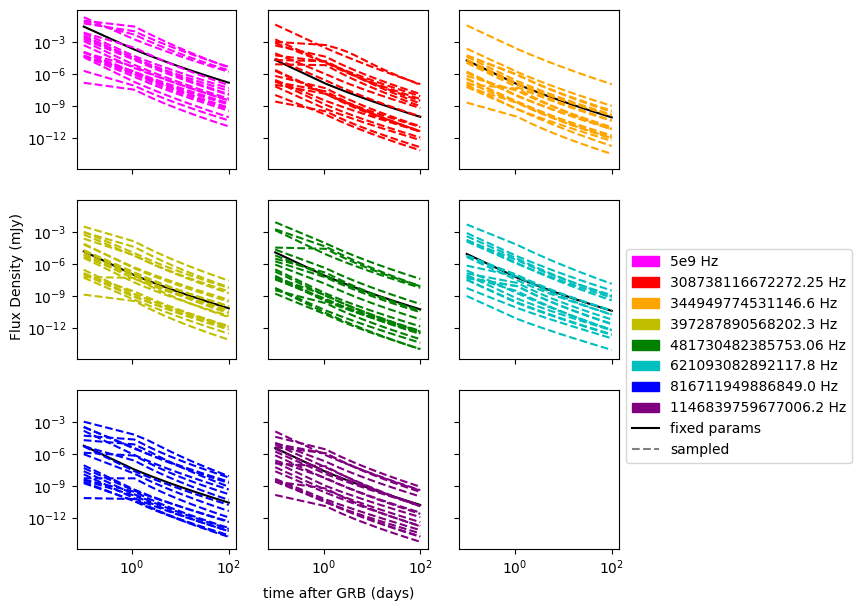

In [6]:
time= np.linspace(0.1,100,100)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(7,7), sharex=True, sharey=True)

ax[0,0].loglog(time, afterglowon(time, frequencies[0]), c='k')
ax[0,1].loglog(time, afterglowon(time, frequencies[1]), c='k')
ax[0,2].loglog(time, afterglowon(time, frequencies[2]), c='k')
ax[1,0].loglog(time, afterglowon(time, frequencies[3]), c='k')
ax[1,1].loglog(time, afterglowon(time, frequencies[4]), c='k')
ax[1,2].loglog(time, afterglowon(time, frequencies[5]), c='k')
ax[2,0].loglog(time, afterglowon(time, frequencies[6]), c='k')
ax[2,1].loglog(time, afterglowon(time, frequencies[7]), c='k')
#ax[2,2].loglog(time, afterglowon(time, frequencies[8]), c='k')

for i in range(20):
    ax[0,0].loglog(time, sampleon(time, frequencies[0]), c='magenta', ls='--')
    ax[0,1].loglog(time, sampleon(time, frequencies[1]), c='r', ls='--')
    ax[0,2].loglog(time, sampleon(time, frequencies[2]), c='orange', ls='--')
    ax[1,0].loglog(time, sampleon(time, frequencies[3]), c='y', ls='--')
    ax[1,1].loglog(time, sampleon(time, frequencies[4]), c='g', ls='--')
    ax[1,2].loglog(time, sampleon(time, frequencies[5]), c='c', ls='--')
    ax[2,0].loglog(time, sampleon(time, frequencies[6]), c='b', ls='--')
    ax[2,1].loglog(time, sampleon(time, frequencies[7]), c='purple', ls='--')    
    #ax[2,2].plot(time, sampled(time, frequencies[8]), c='k', ls='--')
    
f1 = mpatches.Patch(color='magenta', label='5e9 Hz')
f2 = mpatches.Patch(color='r', label='308738116672272.25 Hz')
f3 = mpatches.Patch(color='orange', label='344949774531146.6 Hz')
f4 = mpatches.Patch(color='y', label='397287890568202.3 Hz')
f5 = mpatches.Patch(color='g', label='481730482385753.06 Hz')
f6 = mpatches.Patch(color='c', label='621093082892117.8 Hz')
f7 = mpatches.Patch(color='b', label='816711949886849.0 Hz')
f8 = mpatches.Patch(color='purple', label='1146839759677006.2 Hz')
#f9 = mpatches.Patch(color='k', label='2e17 Hz')
fix = Line2D([0],[0],color='k', ls='solid', label='fixed params')
samp = Line2D([0],[0],color='grey', ls='dashed',label='sampled')

fig.text(0.5, 0.04, 'time after GRB (days)', ha='center')
fig.text(0.03, 0.5, 'Flux Density (mJy)', va='center', rotation='vertical')

plt.legend(handles=[f1,f2,f3,f4,f5,f6,f7,f8, fix, samp], loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()

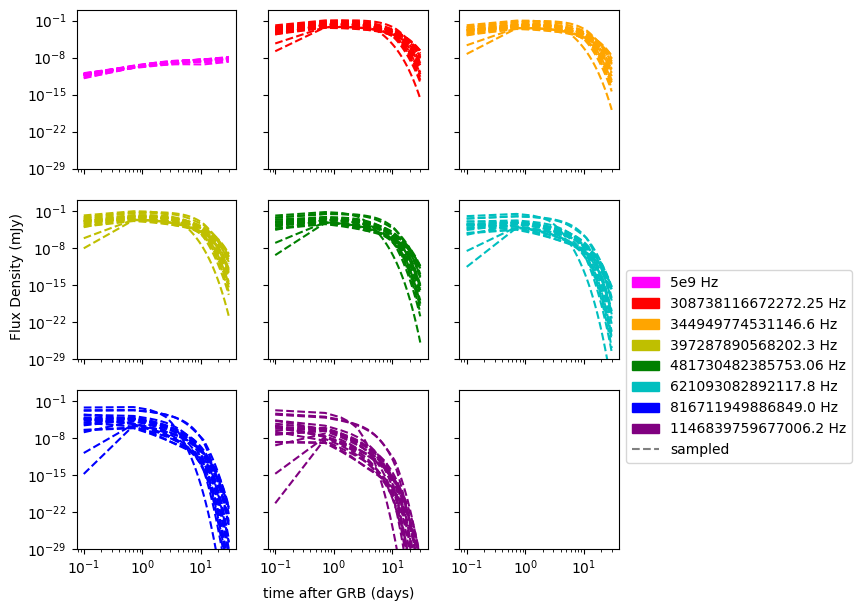

In [30]:
time= np.linspace(0.1,30,50)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(7,7), sharex=True, sharey=True)

for i in range(20):
    ax[0,0].loglog(time, knsample(time, frequencies[0],**kn_data.iloc[i]), c='magenta', ls='--')
    ax[0,1].loglog(time, knsample(time, frequencies[1],**kn_data.iloc[i]), c='r', ls='--')
    ax[0,2].loglog(time, knsample(time, frequencies[2],**kn_data.iloc[i]), c='orange', ls='--')
    ax[1,0].loglog(time, knsample(time, frequencies[3],**kn_data.iloc[i]), c='y', ls='--')
    ax[1,1].loglog(time, knsample(time, frequencies[4],**kn_data.iloc[i]), c='g', ls='--')
    ax[1,2].loglog(time, knsample(time, frequencies[5],**kn_data.iloc[i]), c='c', ls='--')
    ax[2,0].loglog(time, knsample(time, frequencies[6],**kn_data.iloc[i]), c='b', ls='--')
    ax[2,1].loglog(time, knsample(time, frequencies[7],**kn_data.iloc[i]), c='purple', ls='--')    
    #ax[2,2].plot(time, sampled(time, frequencies[8]), c='k', ls='--')
plt.ylim(10e-30,10) 

f1 = mpatches.Patch(color='magenta', label='5e9 Hz')
f2 = mpatches.Patch(color='r', label='308738116672272.25 Hz')
f3 = mpatches.Patch(color='orange', label='344949774531146.6 Hz')
f4 = mpatches.Patch(color='y', label='397287890568202.3 Hz')
f5 = mpatches.Patch(color='g', label='481730482385753.06 Hz')
f6 = mpatches.Patch(color='c', label='621093082892117.8 Hz')
f7 = mpatches.Patch(color='b', label='816711949886849.0 Hz')
f8 = mpatches.Patch(color='purple', label='1146839759677006.2 Hz')
#f9 = mpatches.Patch(color='k', label='2e17 Hz')
#fix = Line2D([0],[0],color='k', ls='solid', label='fixed params')
samp = Line2D([0],[0],color='grey', ls='dashed',label='sampled')

fig.text(0.5, 0.04, 'time after GRB (days)', ha='center')
fig.text(0.03, 0.5, 'Flux Density (mJy)', va='center', rotation='vertical')

plt.legend(handles=[f1,f2,f3,f4,f5,f6,f7,f8, samp], loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()

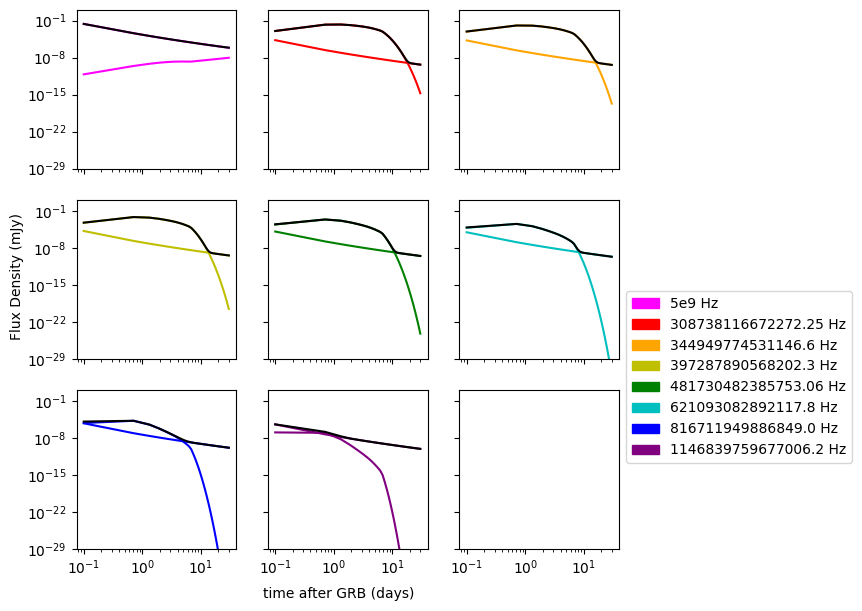

In [51]:
time= np.linspace(0.1,30,50)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(7,7), sharex=True, sharey=True)

ax[0,0].loglog(time, afterglowon(time, frequencies[0]), c='magenta')
ax[0,1].loglog(time, afterglowon(time, frequencies[1]), c='r')
ax[0,2].loglog(time, afterglowon(time, frequencies[2]), c='orange')
ax[1,0].loglog(time, afterglowon(time, frequencies[3]), c='y')
ax[1,1].loglog(time, afterglowon(time, frequencies[4]), c='g')
ax[1,2].loglog(time, afterglowon(time, frequencies[5]), c='c')
ax[2,0].loglog(time, afterglowon(time, frequencies[6]), c='b')
ax[2,1].loglog(time, afterglowon(time, frequencies[7]), c='purple')
#ax[2,2].loglog(time, afterglowon(time, frequencies[8]), c='k')

ax[0,0].loglog(time, knsample(time, frequencies[0], **kn_data.iloc[1]), c='magenta')
ax[0,1].loglog(time, knsample(time, frequencies[1],**kn_data.iloc[1]), c='r')
ax[0,2].loglog(time, knsample(time, frequencies[2],**kn_data.iloc[1]), c='orange')
ax[1,0].loglog(time, knsample(time, frequencies[3],**kn_data.iloc[1]), c='y')
ax[1,1].loglog(time, knsample(time, frequencies[4],**kn_data.iloc[1]), c='g')
ax[1,2].loglog(time, knsample(time, frequencies[5],**kn_data.iloc[1]), c='c')
ax[2,0].loglog(time, knsample(time, frequencies[6],**kn_data.iloc[1]), c='b')
ax[2,1].loglog(time, knsample(time, frequencies[7],**kn_data.iloc[1]), c='purple')
#ax[2,2].loglog(time, afterglowon(time, frequencies[8]), c='k')

ax[0,0].loglog(time, afterglowon(time, frequencies[0]) + knsample(time, frequencies[0],**kn_data.iloc[1]), c='k')
ax[0,1].loglog(time, afterglowon(time, frequencies[1]) + knsample(time, frequencies[1],**kn_data.iloc[1]), c='k')
ax[0,2].loglog(time, afterglowon(time, frequencies[2]) + knsample(time, frequencies[2],**kn_data.iloc[1]), c='k')
ax[1,0].loglog(time, afterglowon(time, frequencies[3]) + knsample(time, frequencies[3],**kn_data.iloc[1]), c='k')
ax[1,1].loglog(time, afterglowon(time, frequencies[4]) + knsample(time, frequencies[4],**kn_data.iloc[1]), c='k')
ax[1,2].loglog(time, afterglowon(time, frequencies[5]) + knsample(time, frequencies[5],**kn_data.iloc[1]), c='k')
ax[2,0].loglog(time, afterglowon(time, frequencies[6]) + knsample(time, frequencies[6],**kn_data.iloc[1]), c='k')
ax[2,1].loglog(time, afterglowon(time, frequencies[7]) + knsample(time, frequencies[7],**kn_data.iloc[1]), c='k')
#ax[2,2].loglog(time, afterglowon(time, frequencies[8]), c='k')

f1 = mpatches.Patch(color='magenta', label='5e9 Hz')
f2 = mpatches.Patch(color='r', label='308738116672272.25 Hz')
f3 = mpatches.Patch(color='orange', label='344949774531146.6 Hz')
f4 = mpatches.Patch(color='y', label='397287890568202.3 Hz')
f5 = mpatches.Patch(color='g', label='481730482385753.06 Hz')
f6 = mpatches.Patch(color='c', label='621093082892117.8 Hz')
f7 = mpatches.Patch(color='b', label='816711949886849.0 Hz')
f8 = mpatches.Patch(color='purple', label='1146839759677006.2 Hz')
#f9 = mpatches.Patch(color='k', label='2e17 Hz')
#fix = Line2D([0],[0],color='k', ls='solid', label='fixed params')
#samp = Line2D([0],[0],color='grey', ls='dashed',label='sampled')

plt.ylim(10e-30,10) 

fig.text(0.5, 0.04, 'time after GRB (days)', ha='center')
fig.text(0.03, 0.5, 'Flux Density (mJy)', va='center', rotation='vertical')

plt.legend(handles=[f1,f2,f3,f4,f5,f6,f7,f8], loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()

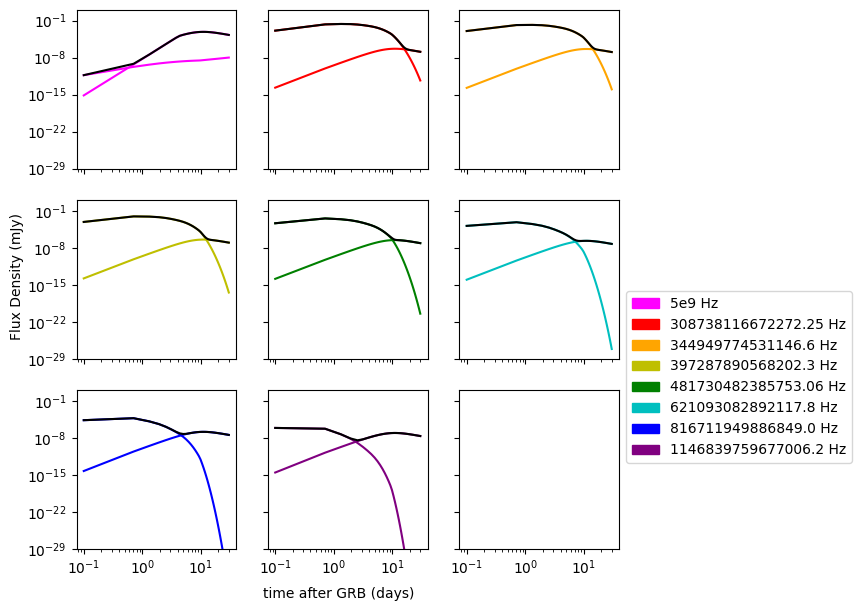

In [195]:
time= np.linspace(0.1,30,50)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(7,7), sharex=True, sharey=True)

ax[0,0].loglog(time, afterglowoff(time, frequencies[0]), c='magenta')
ax[0,1].loglog(time, afterglowoff(time, frequencies[1]), c='r')
ax[0,2].loglog(time, afterglowoff(time, frequencies[2]), c='orange')
ax[1,0].loglog(time, afterglowoff(time, frequencies[3]), c='y')
ax[1,1].loglog(time, afterglowoff(time, frequencies[4]), c='g')
ax[1,2].loglog(time, afterglowoff(time, frequencies[5]), c='c')
ax[2,0].loglog(time, afterglowoff(time, frequencies[6]), c='b')
ax[2,1].loglog(time, afterglowoff(time, frequencies[7]), c='purple')
#ax[2,2].loglog(time, afterglowon(time, frequencies[8]), c='k')

ax[0,0].loglog(time, knsample(time, frequencies[0], **kn_data.iloc[13]), c='magenta')
ax[0,1].loglog(time, knsample(time, frequencies[1],**kn_data.iloc[13]), c='r')
ax[0,2].loglog(time, knsample(time, frequencies[2],**kn_data.iloc[13]), c='orange')
ax[1,0].loglog(time, knsample(time, frequencies[3],**kn_data.iloc[13]), c='y')
ax[1,1].loglog(time, knsample(time, frequencies[4],**kn_data.iloc[13]), c='g')
ax[1,2].loglog(time, knsample(time, frequencies[5],**kn_data.iloc[13]), c='c')
ax[2,0].loglog(time, knsample(time, frequencies[6],**kn_data.iloc[13]), c='b')
ax[2,1].loglog(time, knsample(time, frequencies[7],**kn_data.iloc[13]), c='purple')
#ax[2,2].loglog(time, afterglowon(time, frequencies[8]), c='k')

ax[0,0].loglog(time, afterglowoff(time, frequencies[0]) + knsample(time, frequencies[0],**kn_data.iloc[13]), c='k')
ax[0,1].loglog(time, afterglowoff(time, frequencies[1]) + knsample(time, frequencies[1],**kn_data.iloc[13]), c='k')
ax[0,2].loglog(time, afterglowoff(time, frequencies[2]) + knsample(time, frequencies[2],**kn_data.iloc[13]), c='k')
ax[1,0].loglog(time, afterglowoff(time, frequencies[3]) + knsample(time, frequencies[3],**kn_data.iloc[13]), c='k')
ax[1,1].loglog(time, afterglowoff(time, frequencies[4]) + knsample(time, frequencies[4],**kn_data.iloc[13]), c='k')
ax[1,2].loglog(time, afterglowoff(time, frequencies[5]) + knsample(time, frequencies[5],**kn_data.iloc[13]), c='k')
ax[2,0].loglog(time, afterglowoff(time, frequencies[6]) + knsample(time, frequencies[6],**kn_data.iloc[13]), c='k')
ax[2,1].loglog(time, afterglowoff(time, frequencies[7]) + knsample(time, frequencies[7],**kn_data.iloc[13]), c='k')
#ax[2,2].loglog(time, afterglowon(time, frequencies[8]), c='k')

f1 = mpatches.Patch(color='magenta', label='5e9 Hz')
f2 = mpatches.Patch(color='r', label='308738116672272.25 Hz')
f3 = mpatches.Patch(color='orange', label='344949774531146.6 Hz')
f4 = mpatches.Patch(color='y', label='397287890568202.3 Hz')
f5 = mpatches.Patch(color='g', label='481730482385753.06 Hz')
f6 = mpatches.Patch(color='c', label='621093082892117.8 Hz')
f7 = mpatches.Patch(color='b', label='816711949886849.0 Hz')
f8 = mpatches.Patch(color='purple', label='1146839759677006.2 Hz')
#f9 = mpatches.Patch(color='k', label='2e17 Hz')
#fix = Line2D([0],[0],color='k', ls='solid', label='fixed params')
#samp = Line2D([0],[0],color='grey', ls='dashed',label='sampled')

plt.ylim(10e-30,10) 

fig.text(0.5, 0.04, 'time after GRB (days)', ha='center')
fig.text(0.03, 0.5, 'Flux Density (mJy)', va='center', rotation='vertical')

plt.legend(handles=[f1,f2,f3,f4,f5,f6,f7,f8], loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()

